# **Final Predictions**
---

This notebook combines the trained classification models (Smart-seq and Drop-seq) to perform final predictions on the held-out external test sets. We apply soft-voting ensembles based on the best-performing classifiers from cross-validation, and generate tab-delimited outputs with predicted labels per cell.

We ensure reproducibility by loading saved models and applying them to consistently preprocessed test data. The ensembling strategy prioritizes interpretability and robustness.

> Each step is repeated for both **Smart-seq** and **Drop-seq** datasets, maintaining the same methodology for consistent comparison and integration.

## Index

1. [Load Final Gene Lists](#1-load-final-gene-lists)  
2. [Load and Align External Test Sets](#2-load-and-align-external-test-sets)   
3. [Ensembling](#3-ensembling)
4. [Export Final Predictions](#4-export-final-predictions)
5. [SHAP Interpretation](#5-shap-interpretation)
6. [Conclusion](#6-conclusion)


In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from pathlib import Path
import shap
from scipy.special import expit

## **1.** Load Final Gene Lists
---

We load the gene sets selected for Smart-seq and Drop-seq. These represent the minimal robust gene subsets used by the final classifiers.

#### ***SmartSeq***


In [2]:
with open("stable_genes_mcf_smart.txt") as f:
    stable_genes_smart = [line.strip() for line in f if line.strip()]

#### ***DropSeq***

In [3]:
with open("stable_genes_mcf_drop.txt") as f:
    stable_genes_drop = [line.strip() for line in f if line.strip()]

## **2.** Load and Align External Test Sets
---

We preprocess the external test matrices to match the training format. Only the selected genes are used for prediction, as expected by the saved models.

#### ***SmartSeq***

In [4]:
# Load Smart-seq test
df_test_smart = pd.read_csv("../Data/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_test_anonim.txt", sep=r"\s+", engine= "python", index_col=0).rename(index=lambda x: x.strip('"')).rename(columns=lambda x: x.strip('"')).T
X_test_smart = df_test_smart[stable_genes_smart]

#### ***DropSeq***

In [5]:
df_test_drop = pd.read_csv("../Data/DropSeq/MCF7_Filtered_Normalised_3000_Data_test_anonim.txt", sep=r"\s+", engine= "python", index_col=0).rename(index=lambda x: x.strip('"')).rename(columns=lambda x: x.strip('"')).T
X_test_drop = df_test_drop[stable_genes_drop]

## **3.** Ensembling
---

During cross-validation, several classifiers were evaluated on the training dataset, including Logistic Regression, Support Vector Machines, Random Forests, K-Nearest Neighbors, MLPs, and XGBoost. 
We observed that multiple models achieved similarly strong performance on both Smart-seq and Drop-seq datasets, with ROC AUC values exceeding 0.98 in all cases.

Instead of including all models in the ensemble, we selected the **top 2–3 per technology** based on:
- **Cross-validated performance** (e.g., ROC AUC, F1 score)
- **Model diversity** (linear, neural, kernel-based)
- **Generalization potential**, avoiding redundant predictors

This leads to the following model ensembles:
- **Smart-seq**: SVM, MLP, Logistic Regression
- **Drop-seq**: XGBoost, MLP, SVM

We then generate final predictions on the external test sets using a soft-voting ensemble of the top 3 models per technology. For each cell, we average the predicted probabilities from all ensemble members and apply a 0.5 threshold to obtain binary class labels (0 = Normoxia, 1 = Hypoxia).

This method allows us to combine diverse decision boundaries while smoothing out individual model variance, yielding a robust and generalizable final prediction.

In [6]:
def load_model(name, path, suffix="MCF"):
    with open(Path(path) / f"{name}.{suffix}.pkl", "rb") as f:
        return pickle.load(f)

### ***SmartSeq***


We prepared an ensemble of Logistic, SVM, and XGBoost to guard against possible future batch effects or minor distribution shifts.  

On present data, the three classifiers make identical predictions (error overlap = 100 %)—thus the ensemble does not improve accuracy today. However, by combining diverse inductive biases, we reduce the risk that an unforeseen outlier will fool all three models simultaneously.

In [7]:
Xs_test_log = np.log1p(X_test_smart)

In [8]:
# Load models
model_svm_smart = load_model("SVM", "Models_smart")
model_xgb_smart = load_model("XGBoost", "Models_smart")
model_log_smart = load_model("Logistic", "Models_smart")

# Compute predicted probabilities for class 1 (hypoxia)
probas_smart = np.array([
    model_svm_smart.predict_proba(Xs_test_log)[:, 1],   # SVM Pipeline will scale internally
    model_xgb_smart.predict_proba(Xs_test_log)[:, 1],
    model_log_smart.predict_proba(Xs_test_log)[:, 1],   # Logistic Pipeline will scale internally
])
proba_smart_avg = probas_smart.mean(axis=0)
pred_smart = (proba_smart_avg >= 0.5).astype(int)

> Note on why 0.5 threshold: If hypoxic vs. normoxic cells are roughly 50:50 in your validation set, and you treat a false‐positive error (calling normoxic → hypoxic) as equally “bad” as a false‐negative (calling hypoxic → normoxic), then 0.5 is exactly the Bayes‐optimal threshold for a well‐calibrated model.

### ***DropSeq***

Although each model (Logistic, XGBoost, MLP, SVM, KNN) individually achieved 93–95 % F1 and 93–95 % accuracy on the Drop‐seq held‐out validation set, we formed a small ensemble of the top three diverse learners - SVM, MLP, and XGBoost — to safeguard against potential future batch effects.

In [9]:
Xd_test_log = np.log1p(X_test_drop)

In [10]:
# DROP-SEQ ENSEMBLE: XGBoost + MLP + SVM
model_xgb_drop = load_model("XGBoost", "Models_drop")
model_mlp_drop = load_model("MLP", "Models_drop")
model_svm_drop = load_model("SVM", "Models_drop")

probas_drop = np.array([
    model_xgb_drop.predict_proba(Xd_test_log)[:, 1],
    model_mlp_drop.predict_proba(Xd_test_log)[:, 1],   # MLP Pipeline will scale internally
    model_svm_drop.predict_proba(Xd_test_log)[:, 1],   # SVM Pipeline will scale internally
])
proba_drop_avg = probas_drop.mean(axis=0)
pred_drop = (proba_drop_avg >= 0.5).astype(int)

## **4.** Export Final Predictions
---

We export the ensemble predictions as tab-delimited `.tsv` files, containing one row per cell with its predicted label. These files are ready for submission or evaluation.

### ***SmartSeq***

In [11]:
df_output_smart = pd.DataFrame({
    "Predicted_Label": pred_smart
}, index=X_test_smart.index)

df_output_smart.index.name = "Cell_ID"  # Optional: name the index for clarity
print(df_output_smart)

df_output_smart.to_csv("Smartseq_Predictions.tsv", sep="\t")

         Predicted_Label
Cell_ID                 
1                      1
2                      1
3                      0
4                      0
5                      0
...                  ...
59                     1
60                     1
61                     1
62                     0
63                     0

[63 rows x 1 columns]


### ***DropSeq***

In [12]:
df_output_drop = pd.DataFrame({
    "Predicted_Label": pred_drop
}, index=X_test_drop.index)

df_output_drop.index.name = "Cell_ID"  # Optional: name the index for clarity
print(df_output_drop)

df_output_drop.to_csv("Dropseq_Predictions.tsv", sep="\t")

         Predicted_Label
Cell_ID                 
1                      1
2                      0
3                      0
4                      1
5                      1
...                  ...
5402                   1
5403                   0
5404                   1
5405                   0
5406                   1

[5406 rows x 1 columns]


## **5.** SHAP Interpretation
---

To interpret the predictions, we use SHAP (SHapley Additive exPlanations). SHAP assigns each feature (gene) a contribution score for each prediction, allowing us to understand which genes are driving decisions at both global and per-cell levels.

### **5.1.** ***Smart-seq*** *(Logistic Regression)*

For Smart-seq, we selected **Logistic Regression** as the model to interpret because:
- It performed well in cross-validation
- It is sparse and interpretable
- SHAP integrates natively with linear models via `LinearExplainer`

This approach lets us analyze how much each gene pushes the prediction toward Normoxia (0) or Hypoxia (1), globally and for individual cells.

In [13]:
df_test_smart = pd.read_csv("../Data/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_test_anonim.txt", sep=r"\s+", engine= "python", index_col=0).rename(index=lambda x: x.strip('"')).rename(columns=lambda x: x.strip('"')).T

In [14]:
model_log_smart = pickle.load(open("Models_smart/Logistic.MCF.pkl", "rb"))

In [15]:
Xs_test_subset = df_test_smart[stable_genes_smart]
Xs_test_log_shap = np.log1p(Xs_test_subset)

In [16]:
scaler = model_log_smart.named_steps["scaler"]

Xs_test_scaled = pd.DataFrame(
    scaler.transform(Xs_test_log_shap),
    index=Xs_test_log.index,
    columns=Xs_test_log.columns
)

In [17]:
# Build a SHAP Explainer for the logistic classifier ---
clf_log_smart = model_log_smart.named_steps["clf"]  # extract the LogisticRegression

masker = shap.maskers.Independent(Xs_test_scaled)
explainer_smart = shap.Explainer(clf_log_smart, masker, algorithm="linear")

# Compute SHAP values on the scaled test data
shap_values_smart = explainer_smart.shap_values(Xs_test_scaled)

#### - *Global SHAP Feature Importance*

This plot shows the average absolute SHAP value for each gene across all Smart-seq cells. Genes with higher values contribute more strongly to predictions.

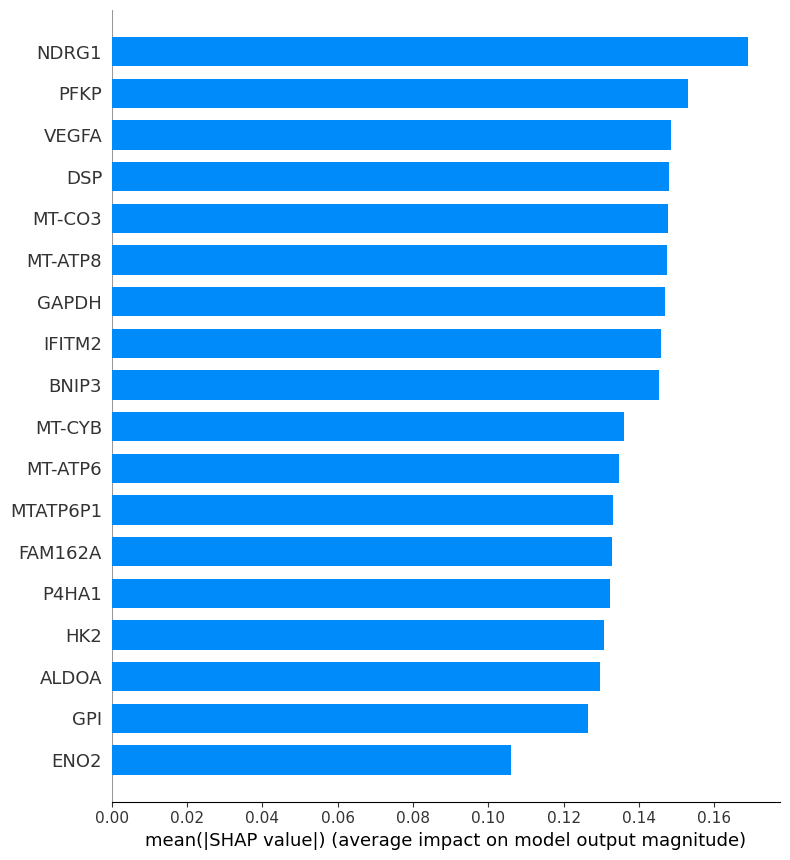

In [18]:
shap.summary_plot(
    shap_values_smart,     # or just shap_values_smart (either works for bar)
    features=None,                # no matrix needed when plot_type="bar"
    feature_names=stable_genes_smart,
    plot_type="bar"
)

#### - *SHAP Value Distribution by Gene*

This violin plot shows the distribution of SHAP values for each gene, colored by expression. Red areas represent higher expression.

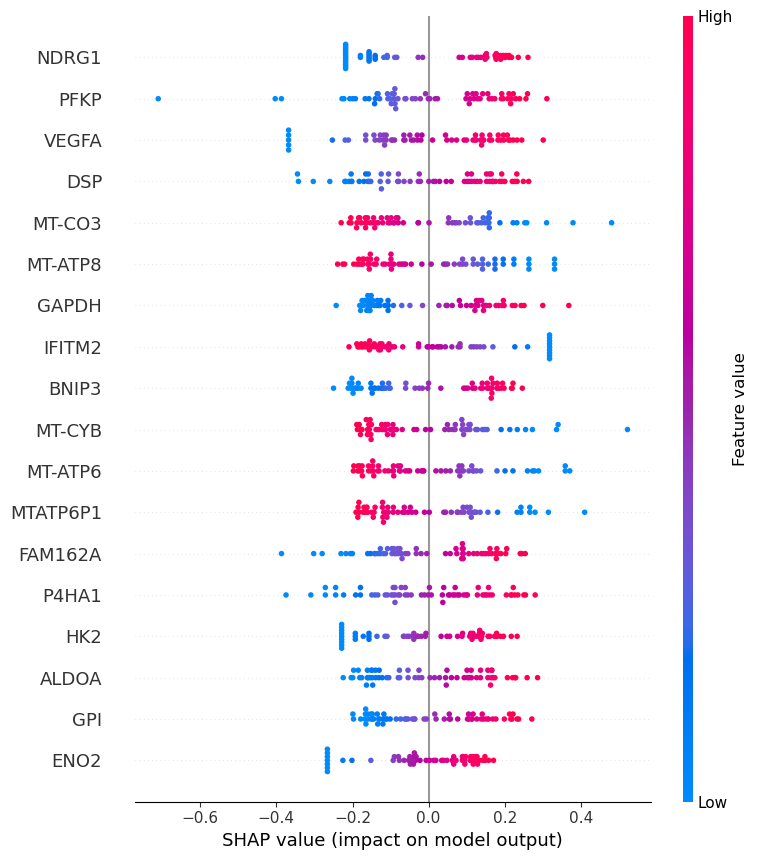

In [19]:
shap.summary_plot(
    shap_values_smart, 
    Xs_test_log,            # unscaled log1p matrix of shape (n_cells, 12)
    feature_names=stable_genes_smart
)

| Plot Feature | Interpretation |
|--------------|----------------|
| **Y-axis (genes)** | Genes ranked by importance (top = most influential) |
| **X-axis (SHAP value)** | Impact on model output:<br> • Positive → pushes toward **Hypoxia (1)**<br> • Negative → pushes toward **Normoxia (0)** |
| **Dot (each point)** | One cell from the test dataset |
| **Dot color** | Expression of the gene in that cell:<br> • **Red** = high expression<br> • **Blue** = low expression |
| **Wider violin (dense points)** | Many cells had similar SHAP impact for that gene |
| **Red dots on the right** | High expression of this gene **increases hypoxia prediction** |
| **Blue dots on the right** | Low expression of this gene **increases hypoxia prediction** |
| **Symmetric shape around 0** | Gene has less directional influence; impact is context-specific or neutral |

**Example interpretations**:
- **PFKP**: High expression (red) mostly on the right → upregulation pushes toward hypoxia.
- **MT-CYB**: Low expression (blue) strongly pushes toward hypoxia.
- **FAM162A**: More moderate effect, symmetric → weaker influence.

This plot gives both a global sense of gene importance and insights into how expression levels influence model decisions across individual cells.

#### - *Local Explanation*

This force plot shows how each gene influences the prediction for an individual cell. Red bars push the prediction toward hypoxia, blue toward normoxia. The longer the bar, the greater the contribution.

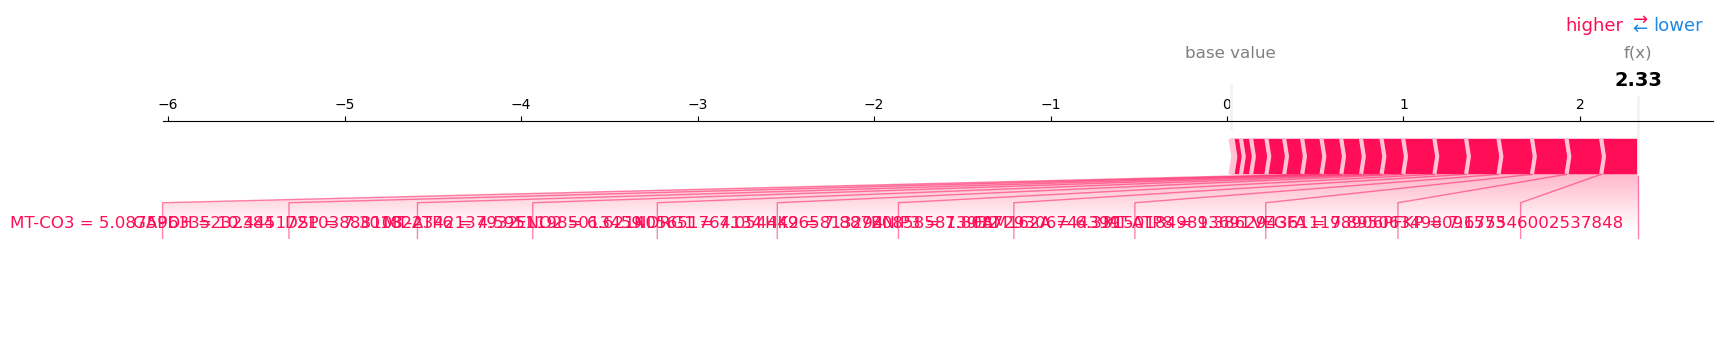

In [20]:
i = 0  # whichever row you want to explain

shap.force_plot(
    explainer_smart.expected_value,        # model’s base output (log-odds)
    shap_values_smart[i],           # SHAP values for cell i (length 12)
    Xs_test_log_shap.iloc[i],             # the UNscaled log1p values of those 12 genes
    feature_names=stable_genes_smart,
    matplotlib=True
)

- **Red bars**: Genes pushing the prediction toward **Hypoxia (1)**.
- **Blue bars**: Genes pushing the prediction toward **Normoxia (0)**.
- **Length of bar**: Magnitude of the gene's contribution.
- **f(x)**: The final logit score before applying the sigmoid (i.e., raw model output).
- **Interpretation**: The force plot explains *why* the model predicted a specific label for one individual cell.


### **5.2.** ***Drop-seq*** *(XGBoost)*
We now interpret the predictions of our XGBoost model trained on Drop-seq data. SHAP will help us identify which genes most influence hypoxia classification in individual test cells.

We start by loading the test dataset and preparing it with the same feature subset used in training (stable genes selected via MI + L1 + RF stability).

In [22]:
df_test_drop = pd.read_csv("../Data/DropSeq/MCF7_Filtered_Normalised_3000_Data_test_anonim.txt", sep=r"\s+", engine= "python", index_col=0).rename(index=lambda x: x.strip('"')).rename(columns=lambda x: x.strip('"')).T

In [23]:
model_xgb_drop = pickle.load(open("Models_drop/XGBoost.MCF.pkl", "rb"))

In [24]:
# Subset to selected features
Xd_test_subset = df_test_drop[stable_genes_drop]
Xd_test_log_shap = np.log1p(Xd_test_subset)
Xd_test_log_df = pd.DataFrame(
    Xd_test_log_shap,
    index=Xd_test_subset.index,
    columns=stable_genes_drop
)


In [25]:
clf_xgb_drop = model_xgb_drop.named_steps["clf"]

explainer_drop = shap.TreeExplainer(clf_xgb_drop)
shap_values_drop = explainer_drop.shap_values(Xd_test_log_df)

#### - *Global SHAP Feature Importance*

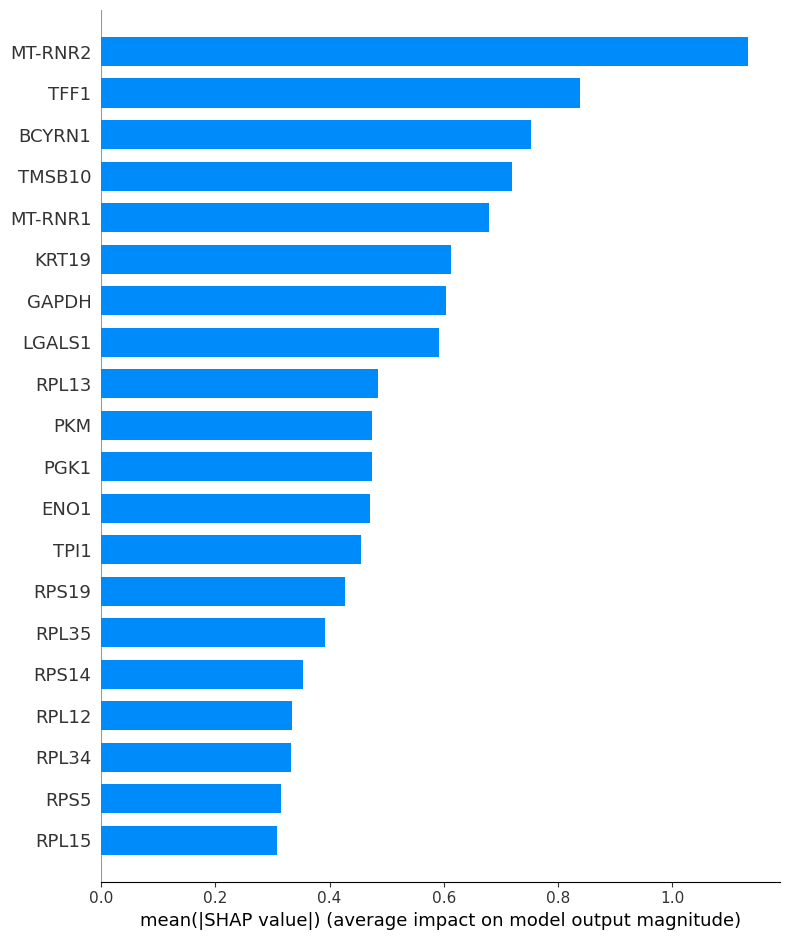

In [26]:
plt.figure(figsize=(6, 4))
shap.summary_plot(
    shap_values_drop, 
    features=None, 
    feature_names=stable_genes_drop,
    plot_type="bar",
    show=True
)

#### - *SHAP Value Distribution by Gene*

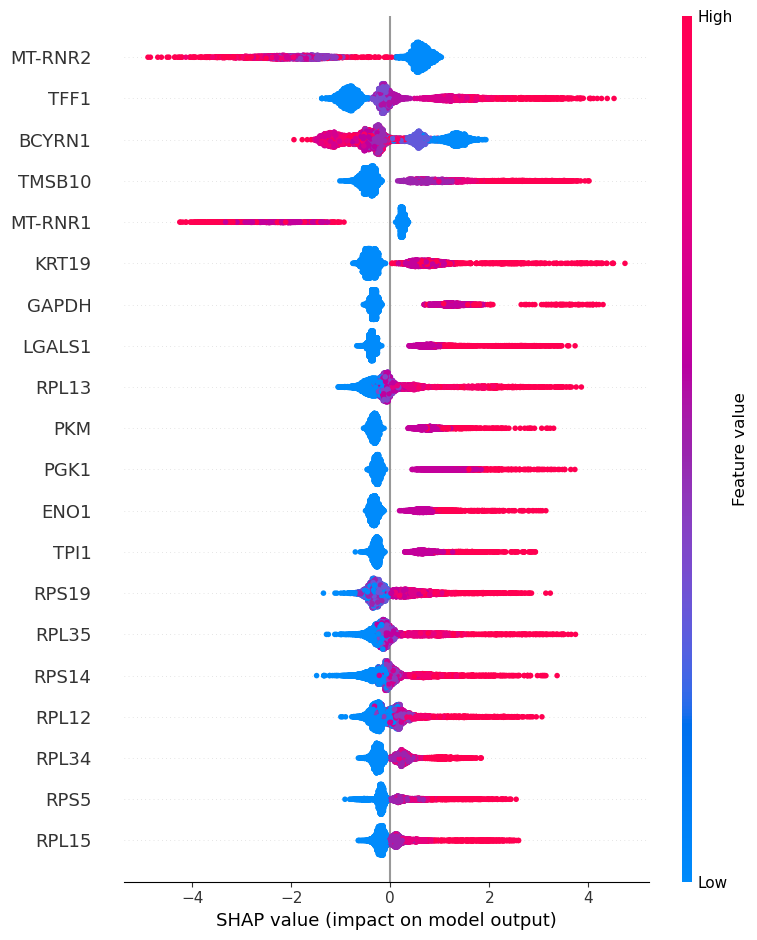

In [27]:
plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values_drop,
    Xd_test_log_df,          # unscaled log1p DataFrame for coloring
    feature_names=stable_genes_drop,
    show=True
)

#### - *Local Explanation*

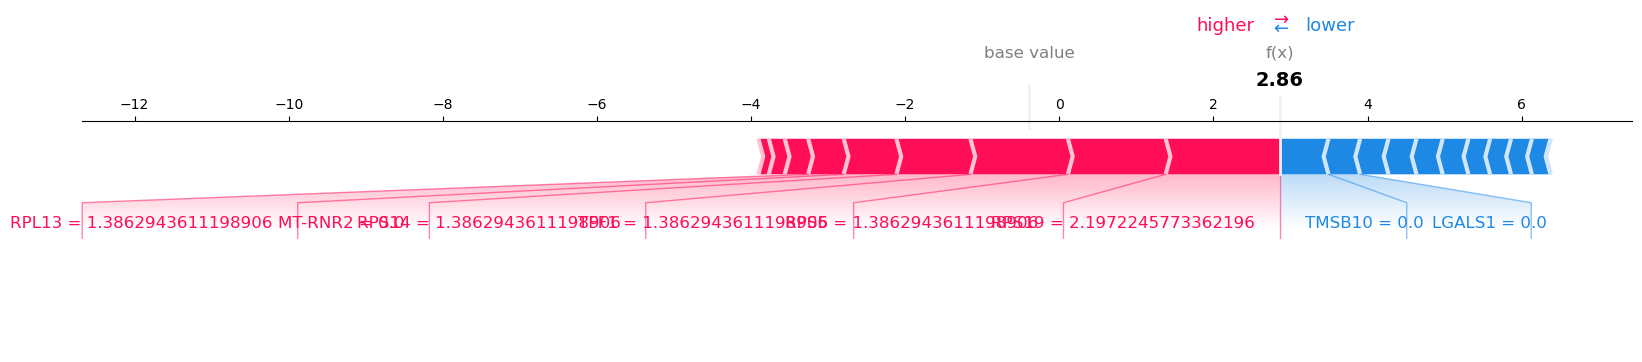

In [28]:
i = 0  # pick a test cell
shap.force_plot(
    explainer_drop.expected_value,
    shap_values_drop[i],
    Xd_test_log_shap.iloc[i],
    matplotlib=True
)

Although our final predictions were generated by an ensemble, we used SHAP to interpret a top-performing and interpretable component (Logistic Regression for Smart-seq, XGBoost for Drop-seq). This allows us to trace biological relevance at the single-gene and single-cell level while maintaining predictive robustness through ensemble voting.